# Sentiment Analysis and Reducing Costs in the Film Industry

## 1. Import libraries

In [1]:
#Libraries
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk # Natural Language Processing
from sklearn.feature_extraction.text import CountVectorizer # Bag of Words
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords  # List of common words usually ignored in text analysis
#from nltk.stem.porter import PorterStemmer  # For stemming using the Porter algorithm
from wordcloud import WordCloud, STOPWORDS  # To create word cloud visualizations from text
from nltk.stem import WordNetLemmatizer  # For lemmatization
from nltk.tokenize import word_tokenize, sent_tokenize  # For word and sentence tokenization
from bs4 import BeautifulSoup  # For HTML and XML parsing (web scraping)
import spacy  # Fast and efficient NLP library
import re, string, unicodedata  # For string manipulation and text normalization
from nltk.tokenize.toktok import ToktokTokenizer  # More efficient tokenizer
from nltk.stem import LancasterStemmer, WordNetLemmatizer  # Alternatives for stemming and lemmatization
from sklearn.linear_model import LogisticRegression, SGDClassifier  # Logistic regression and SGD classifiers for classification
from sklearn.naive_bayes import MultinomialNB  # Classification using Naive Bayes
from textblob import TextBlob  # For text and sentiment analysis
from textblob import Word  # For word processing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # For model evaluation
import time  # For measuring code execution time

import warnings
warnings.filterwarnings('ignore')  # Ignore warnings

## 2. Dataset

In [2]:
imdb_dataset = pd.read_csv('C:/Users/Nosse/IMDBDataset.csv') #load data
print(imdb_dataset.shape)
imdb_dataset.head(16)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


### 2.1 Dataset info

In [3]:
imdb_dataset.describe() #dataset summary

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [4]:
imdb_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


### 2.2 Sentiment count-info

In [5]:
imdb_dataset['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

## 3. Pre-Processing : Cleaning-Text

### 3.1 Remove HTML tags & Noise from the text

In [6]:
#remove html from text
def remove_html(text):
    
    if not isinstance(text, str):
        text = str(text)
        
    ss = BeautifulSoup(text, "html.parser")
    return ss.get_text()
    
#remove text between square brackets
def remove_btw_square_bb(text):
    return re.sub(r'\[[^]]*\]','',text)

#call all the function to clean text
def remove_noise_txt(text):
    text = remove_html(text)
    text = remove_btw_square_bb(text)
    return text

#apply the function
imdb_dataset['review']= imdb_dataset['review'].apply(remove_noise_txt)


#### Explanation:

1. **Removing HTML from text**: the function *remove_html(text)* uses BeautifulSoup to parse HTML content from the given text and extract only text without the tags. Useful fro cleaning reviews that may contain HTML tags.
   
2. **Removing text bewtween square brackets**: the function *remove_btw_square_bb(text)* utilizes a regex (regular expression), to find and remove (replace) any text that appears between square brackets, this helps to eliminate irrelevant information.
   
3. **Removing Noise from text**: the function  *remove_noise_txt(text)* combines the two previous functions, first remove HTML tags and then eliminates text that is enclosed in square brackets.

### 3.2 Removing special CHR

In [7]:
#Function to remove special chr with regex
def remove_sp_CHR(text, remove_digits=True):
    pattern= r'[^a-zA-z0-9\s]'
    text = re.sub(pattern,'',text)
    return text

#Function call
imdb_dataset['review']= imdb_dataset['review'].apply(remove_sp_CHR)

#### Explanation:

### 3.3 Result of Text Cleaned:

In [8]:
imdb_dataset.head(16)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production The filming tech...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically theres a family where a little boy J...,negative
4,Petter Matteis Love in the Time of Money is a ...,positive
5,Probably my alltime favorite movie a story of ...,positive
6,I sure would like to see a resurrection of a u...,positive
7,This show was an amazing fresh innovative ide...,negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


## 4. Exploratory Data Analysis and General Pre-Processing

### 4.1 Null or Duplicate values Detection (columns - rows)

In [9]:
null_var_column = imdb_dataset.isnull().sum() #null values in dataset
print("Null values - each column: \n",null_var_column)

duplicate_rows = imdb_dataset.duplicated().sum() #duplicate rows in dataset
print("\n Duplicates -  rows: \n",duplicate_rows)

Null values - each column: 
 review       0
sentiment    0
dtype: int64

 Duplicates -  rows: 
 419


#### Explanation

### 4.2 Working Features

#### 4.2.1 Review Length

In [10]:
imdb_dataset['review_len'] = imdb_dataset['review'].apply(lambda x: len(x.split())) #Creates a new column with the length (in number of words) of each review.

imdb_dataset.head(10)

,review,sentiment,review_len
0,One of the other reviewers has mentioned that ...,positive,301
1,A wonderful little production The filming tech...,positive,156
2,I thought this was a wonderful way to spend ti...,positive,162
3,Basically theres a family where a little boy J...,negative,129
4,Petter Matteis Love in the Time of Money is a ...,positive,222
5,Probably my alltime favorite movie a story of ...,positive,119
6,I sure would like to see a resurrection of a u...,positive,150
7,This show was an amazing fresh innovative ide...,negative,170
8,Encouraged by the positive comments about this...,negative,124
9,If you like original gut wrenching laughter yo...,positive,31


#### 4.2.2 Unique Review Length and Binning length

In [11]:
unique_len = imdb_dataset['review_len'].unique() #Unique column of rev_len
print("Unique Review Lengths:")
print(unique_len)

Unique Review Lengths:
[ 301  156  162 ... 1062  874 1136]


In [12]:
#Defining binning range and labels
bins= [0,100,500,1000,1500,float('inf')]
labels = ['Short','Medium','Large','Extra Large','Extra Extra Large']

#New Column based on binning rules
imdb_dataset['review_len_binned'] = pd.cut(imdb_dataset['review_len'],bins=bins,labels=labels,right=True)

print(imdb_dataset[['review_len', 'review_len_binned']].head(10)) #display binned length

   review_len review_len_binned
0         301            Medium
1         156            Medium
2         162            Medium
3         129            Medium
4         222            Medium
5         119            Medium
6         150            Medium
7         170            Medium
8         124            Medium
9          31             Short


### 4.3 Sentiment Class Distribution

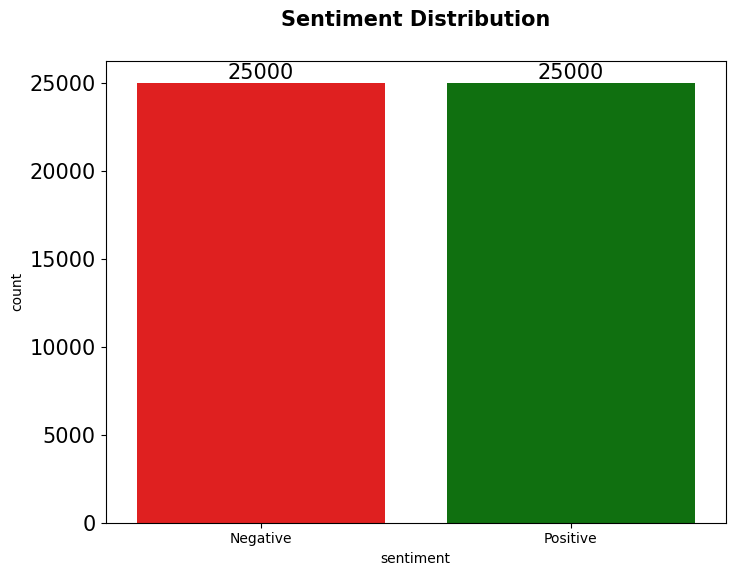

In [13]:
plt.figure(figsize=(8,6)) #plot size

ax= sns.countplot(x='sentiment',data=imdb_dataset, palette=['#FF0000', '#008000']) # define (Axis X)

plt.title('Sentiment Distribution',fontsize=15,weight='bold',ha='center',pad=25) # plot title

#Add counts value above
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',(p.get_x() + p.get_width() /2.,p.get_height()),ha='center', va='bottom', fontsize=15)

ax.set_xticklabels(['Negative','Positive'],ha='center') #Set x-axis labels
ax.tick_params(axis='y', labelsize=15)

#display plot
plt.show() 


#### Note

The Negative and Positive classes are balance in the dataset

### 4.4 Review Length frequency plot

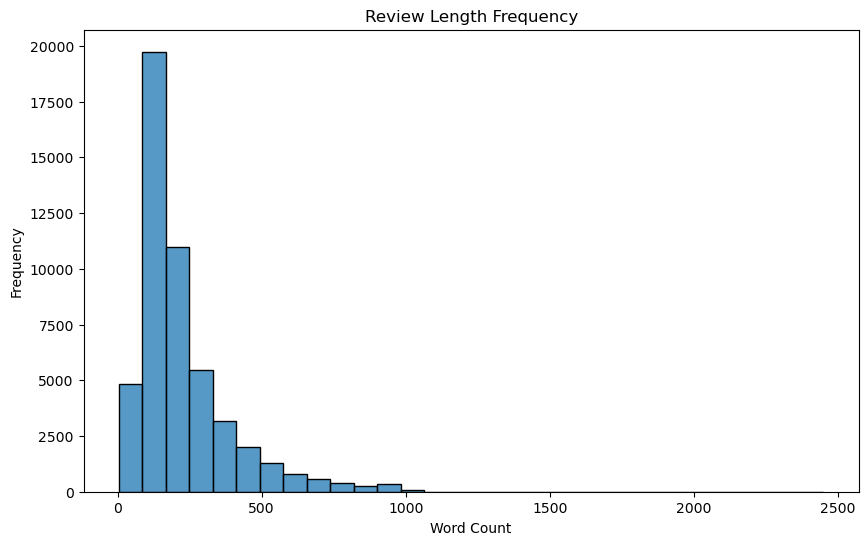

In [14]:
plt.figure(figsize=(10,6))
ax = sns.histplot(imdb_dataset['review_len'],bins=30)

plt.title('Review Length Frequency')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.show()

**The most frequent reviews are those with a word count between 0 and 500**

### 4.5 Does Review Length Influence Sentiment?

In [15]:
#Generate a contingency table that shows how often each combination of review length category and sentiment occurs.
cont_table = pd.crosstab(imdb_dataset['review_len_binned'],imdb_dataset['sentiment']) 

#Calculate percentages on totals for each row
cont_table_perc = cont_table.div(cont_table.sum(axis=1),axis=0)*100 

print(cont_table_perc)

sentiment           negative    positive
review_len_binned                       
Short              46.067245   53.932755
Medium             51.043476   48.956524
Large              45.945946   54.054054
Extra Large        40.625000   59.375000
Extra Extra Large   0.000000  100.000000


**The percentage is calculated on the totals of each row of the contingency table**

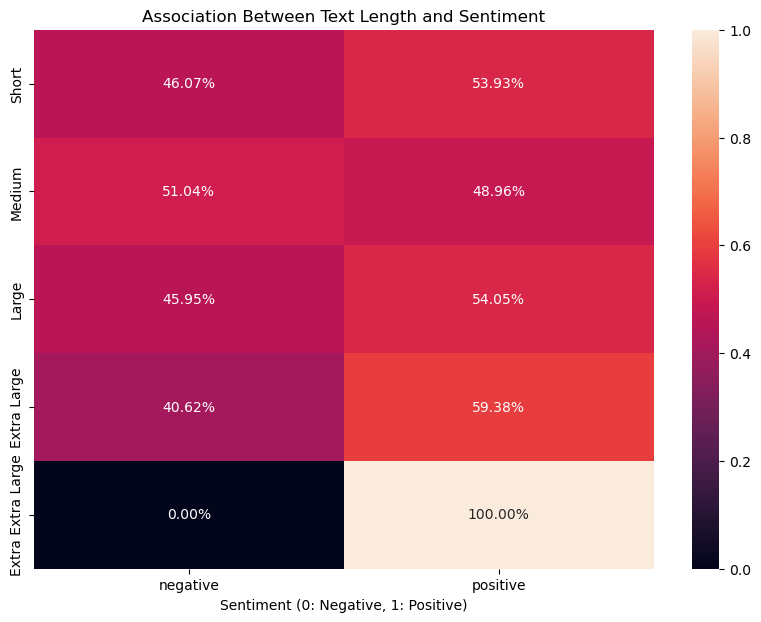

In [16]:
cont_table = pd.crosstab(imdb_dataset['review_len_binned'], imdb_dataset['sentiment'])

cont_table_perc = cont_table.div(cont_table.sum(axis=1), axis=0)

plt.figure(figsize=(10,7))

ax = sns.heatmap(cont_table_perc,annot=True,fmt=".2%",cbar=True)

plt.title("Association Between Text Length and Sentiment")

ax.set_xlabel('Sentiment (0: Negative, 1: Positive)')
ax.set_ylabel('')

plt.show()

**Those who write long reviews tend to motivate a positive judgment**

As the length of the review increases, the likelihood that it will be positive increases

**Short reviews are more critical or neutral.**

Short or medium reviews are more balanced or slightly negative.

**Relevance of Review Length**: there appears to be a positive association between review length and sentiment, indicating that users tend to elaborate more when sharing positive feedback.



Vedere se aggiungere un test di ipotesi adatto chiedere al professore....

### 4.6 Text Normalization & Stop-words & Tokenization

In [17]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer

#download  stop-words
nltk.download('stopwords')

#Tokenization
tokenizer = ToktokTokenizer()

#List of stop-words
stopword_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nosse\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**NLTK Import and Stopword Download**
The code begins by importing the NLTK (Natural Language Toolkit) library, a widely used toolkit for natural language processing. It also downloads the English stopwords set  a collection of frequently occurring words like "and," "is," and "that" which are usually excluded during preprocessing due to their limited contribution to text meaning.

**Tokenizing the Text**
A tokenizer instance using ToktokTokenizer is created. Tokenization refers to splitting the text into smaller components (typically words or phrases), facilitating easier analysis and manipulation.

**Setting English Stopwords**
Using NLTK, the code defines a list of English stopwords. This enables the model to filter out these commonly used terms that don't add significant value to sentiment interpretation.

### 4.7 Optimization : Text Stemming

Stemming is a text preprocessing technique used in Natural Language Processing (NLP) to reduce words to their root or base form, known as the stem. The goal is to treat words with similar meanings (such as "running", "runs", "ran") as a single term, thereby improving the efficiency and effectiveness of text analysis.

In [18]:
#Stemming Function
def stem_txt(txt):
    Ps = nltk.porter.PorterStemmer()
    txt = ' '.join([Ps.stem(word) for word in txt.split()])
    return txt

#Apply f
imdb_dataset['review']=imdb_dataset['review'].apply(stem_txt)



**Stem_txt** : this function applies stemming to a given text using the **Porter Stemmer** from the NLTK library.
Splits the input text into individual words,applies stemming to each word using the **stem()** method.
After all, rebuilds the list of stemmed words into a single string and returns the processed (stemmed) text.

**The stem_txt() function is applied to every review in the review column of the imdb_dataset. The original review texts are replaced with their stemmed versions.**

In [19]:
#Show Stemming result on dataset
print(imdb_dataset['review'].head(10))

0    one of the other review ha mention that after ...
1    a wonder littl product the film techniqu is ve...
2    i thought thi wa a wonder way to spend time on...
3    basic there a famili where a littl boy jake th...
4    petter mattei love in the time of money is a v...
5    probabl my alltim favorit movi a stori of self...
6    i sure would like to see a resurrect of a up d...
7    thi show wa an amaz fresh innov idea in the 70...
8    encourag by the posit comment about thi film o...
9    if you like origin gut wrench laughter you wil...
Name: review, dtype: object


### 4.8 Optimization : Delete Features

In [20]:
imdb_dataset = imdb_dataset.drop(['review_len','review_len_binned'],axis=1)
print(imdb_dataset.head())

                                              review sentiment
0  one of the other review ha mention that after ...  positive
1  a wonder littl product the film techniqu is ve...  positive
2  i thought thi wa a wonder way to spend time on...  positive
3  basic there a famili where a littl boy jake th...  negative
4  petter mattei love in the time of money is a v...  positive


### 4.9 Data Split: Review

In [21]:
from sklearn.model_selection import train_test_split

#Take 80% of the data for training
train_size = int(0.8 * len(imdb_dataset))

#Splitting training and testing sets
n_train_revw = imdb_dataset.review[:train_size]
n_test_revw = imdb_dataset.review[train_size:]
train_sentiments = imdb_dataset.sentiment[:train_size]
test_sentiments = imdb_dataset.sentiment[train_size:]

X_tr = n_train_revw
X_test = n_test_revw

Y_tr = train_sentiments
Y_test = test_sentiments 

print(f"#1 TRAINING REVIEW:\n{X_tr.iloc[0]}\n")
print(f"#1 TESTING REVIEW:\n{X_test.iloc[0]}\n")

print("Train Setiments Len: ", Y_tr.shape)
print("Test Setiments Len: ", Y_test.shape)



#1 TRAINING REVIEW:
one of the other review ha mention that after watch just 1 oz episod youll be hook they are right as thi is exactli what happen with meth first thing that struck me about oz wa it brutal and unflinch scene of violenc which set in right from the word go trust me thi is not a show for the faint heart or timid thi show pull no punch with regard to drug sex or violenc it is hardcor in the classic use of the wordit is call oz as that is the nicknam given to the oswald maximum secur state penitentari it focus mainli on emerald citi an experiment section of the prison where all the cell have glass front and face inward so privaci is not high on the agenda em citi is home to manyaryan muslim gangsta latino christian italian irish and moreso scuffl death stare dodgi deal and shadi agreement are never far awayi would say the main appeal of the show is due to the fact that it goe where other show wouldnt dare forget pretti pictur paint for mainstream audienc forget charm forge

This data split is a **crucial step in building a machine learning model**. The dataset is divided into two parts:

**Training set** 80% (X_train, y_train): Used to train the model, allowing it to learn patterns and relationships between the review text and the corresponding sentiment labels.

**Testing set** 20%(X_test, y_test): Used to evaluate the model’s generalization capability on unseen data. This simulates how the model would perform in real-world scenarios, ensuring that it doesn't just memorize the training data but can actually make accurate predictions on new inputs.

By separating the data, we prevent data leakage and ensure that model evaluation is unbiased and reliable. This approach helps in identifying issues like overfitting or underfitting, which are critical to address when developing robust machine learning solutions.

## 5. Bags of words
The **Bag of Words** is a common technique in *Natural Language Processing (NLP)* used to convert text into numerical form. It represents a document by counting the **occurrences of each word**, ignoring grammar and word order. Only the presence and frequency of words matter.

EX:
| Sentence              | The | cat | eats | fish | dog | meat |
| --------------------- | --- | --- | ---- | ---- | --- | ---- |
| `"The cat eats fish"` | 1   | 1   | 1    | 1    | 0   | 0    |
| `"The dog eats meat"` | 1   | 0   | 1    | 0    | 1   | 1    |


In [22]:
#Count Vector for BoW
vector_cc = CountVectorizer(min_df=1, max_df=1, binary=False, ngram_range=(1,3))

vector_train_rev = vector_cc.fit_transform(n_train_revw)
vector_test_rev = vector_cc.transform(n_test_revw)

print('BOW_vc_train:', vector_train_rev.shape)
print('BOW_vc_test:', vector_test_rev.shape)

BOW_vc_train: (40000, 6030526)
BOW_vc_test: (10000, 6030526)


*This code prepares text data for analysis by converting it into a format that can be understood by machine learning models.*

**Count Vectorizer for Bag of Words**: The code initializes the CountVectorizer, which transforms the text data into a bag-of-words (BoW) representation. This representation counts how many times each word (or combination of words) appears in the reviews. The settings used allow:

    Including words that appear at least once (min_df=1).
    Ignoring words that appear in all documents (max_df=1).
    Creating single words, word pairs, and word triplets as features (ngram_range=(1,3)).
    
**Transforming Reviews**: The code then processes the training reviews (n_train_revw) to create a matrix (vector_train_rev) that shows the count of each word/phrase. It also processes the testing reviews (n_test_revw) to create a separate matrix (vector_test_rev).

**Printing Shapes**: Finally, the code prints the dimensions of the training and testing matrices, showing how many reviews and unique words/phrases are included.

## 6. TFIDF model

### **DEF. of Term Frequency-Inverse Document Frequency model:**

**TF-IDF** is a numerical statistic used in Natural Language Processing (NLP) to measure the importance of a word in a document relative to a collection of documents (corpus). It combines:

* **TF (Term Frequency):** how often a word appears in a document.
* **IDF (Inverse Document Frequency):** how rare the word is across all documents.

The result helps highlight words that are both frequent in a specific document and distinctive across the corpus, making TF-IDF useful for tasks like text classification, keyword extraction, and information retrieval.


The **TF-IDF score** for a word *t* in a document *d* is calculated as:

$$
\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)
$$

Where:

* **TF(t, d)** = Term Frequency =
  Number of times term *t* appears in document *d*, usually normalized (e.g., divided by total words in the document).

* **IDF(t)** = Inverse Document Frequency =

  $$
  \text{IDF}(t) = \log \left( \frac{N}{1 + \text{DF}(t)} \right)
  $$

  * *N* = Total number of documents
  * *DF(t)* = Number of documents containing the term *t*
  * `1 +` in the denominator avoids division by zero


* **TF** captures how important a word is **within a specific document**.
* **IDF** captures how **unique or rare** the word is **across all documents**.
* The final TF-IDF score highlights words that are **frequent in one document but rare in the entire corpus**, making them more informative.

In [23]:
#Def. TfidfVectorizer
tfidf= TfidfVectorizer(min_df=1,max_df=1, use_idf=True, ngram_range=(1,3))

#Tfidf Train set
tfidf_train_data = tfidf.fit_transform(n_train_revw)

#Tfidf Test set
tfidf_test_data = tfidf.transform(n_test_revw)



print('Tfidf_train:', tfidf_train_data.shape)
print('Tfidf_test:', tfidf_test_data.shape)

Tfidf_train: (40000, 6030526)
Tfidf_test: (10000, 6030526)


*This code uses the **TF-IDF Vectorizer** to convert text data into a numerical format that captures the importance of words in relation to the entire dataset*:


**Def. the TF-IDF Vectorizer**:The code initializes TfidfVectorizer, which transform text into Term Frequency-Inverse Document Frequency (TF-IDF) representation. This approach helps to find the importance of a word in a review relative to the entire dataset. The settings used allow for:

    Including words that appear at least once (min_df=1).
    Ignoring words that appear in all documents (max_df=1).
    Creating single words, word pairs, and word triplets as features (ngram_range=(1,3)).
    
**Transforming Reviews**: This code then processes the training reviews (n_train_revw) to create a matrix (tfidf_train_data) that represents the TF-IDF scores of each word/phrase. It also processes the testing reviews (n_test_revw) to create a separate matrix (tfidf_test_data).

**Printing Shapes**: Finally, this code prints the dimensions of the training and testing matrices, indicating how many reviews and unique words/phrases are included in the TF-IDF representation.

Corpus:

Doc A: *“Jupiter is the largest planet”*

Doc B: *“Mars is the fourth planet from the sun”*

| Term    | TF (A) | TF (B) | IDF           | TF × IDF (A)            | TF × IDF (B) |
| ------- | ------ | ------ | ------------- | ----------------------- | ------------ |
| jupiter | 1/5    | 0      | log(2/1)=0.69 | ≈ 0.138                 | 0            |
| is      | 1/5    | 1/8    | log(2/2)=0    | 0                       | 0            |
| the     | 1/5    | 2/8    | log(2/2)=0    | 0                       | 0            |
| largest | 1/5    | 0      | log(2/1)=0.69 | ≈ 0.138                 | 0            |
| planet  | 1/5    | 1/8    | log(2/2)=0    | 0.138? Actually zero \* | 0            |
| mars    | 0      | 1/8    | log(2/1)=0.69 | 0                       | ≈ 0.086      |
| fourth  | 0      | 1/8    | 0.69          | 0                       | ≈ 0.086      |
| from    | 0      | 1/8    | 0.69          | 0                       | ≈ 0.086      |
| sun     | 0      | 1/8    | 0.69          | 0                       | ≈ 0.086      |

This representation allows machine learning models to give more weight to relevant and specific words for each document, improving classification and information retrieval.

In [24]:
# Get Features
feature_names = tfidf.get_feature_names_out()

# Ex. Docs
n_docs = 2

tfidf_tables = []

for i in range(n_docs):
    # i- row
    row = tfidf_train_data[i]
    row_array = row.toarray().flatten()
    
    # only terms with TF-IDF > 0
    nonzero_indices = row_array.nonzero()[0]
    
    # Build table doc
    terms = [feature_names[j] for j in nonzero_indices]
    scores = [row_array[j] for j in nonzero_indices]
    
    doc_table = pd.DataFrame({
        'Term': terms,
        'TF-IDF Score': scores
    }).sort_values(by='TF-IDF Score', ascending=False)
    
    print(f"\n **Document {i+1}**:")
    print(f"{n_train_revw.iloc[i]}\n")
    
    # Print Tables
    display(doc_table.reset_index(drop=True))



 **Document 1**:
one of the other review ha mention that after watch just 1 oz episod youll be hook they are right as thi is exactli what happen with meth first thing that struck me about oz wa it brutal and unflinch scene of violenc which set in right from the word go trust me thi is not a show for the faint heart or timid thi show pull no punch with regard to drug sex or violenc it is hardcor in the classic use of the wordit is call oz as that is the nicknam given to the oswald maximum secur state penitentari it focus mainli on emerald citi an experiment section of the prison where all the cell have glass front and face inward so privaci is not high on the agenda em citi is home to manyaryan muslim gangsta latino christian italian irish and moreso scuffl death stare dodgi deal and shadi agreement are never far awayi would say the main appeal of the show is due to the fact that it goe where other show wouldnt dare forget pretti pictur paint for mainstream audienc forget charm forget 

,Term,TF-IDF Score
0,about oz wa,0.0635
1,after watch just,0.0635
2,agenda em,0.0635
3,agenda em citi,0.0635
4,agreement are,0.0635
...,...,...
243,wordit is call,0.0635
244,wouldnt dare forget,0.0635
245,you may becom,0.0635
246,your darker,0.0635



 **Document 2**:
a wonder littl product the film techniqu is veri unassum veri oldtimebbc fashion and give a comfort and sometim discomfort sens of realism to the entir piec the actor are extrem well chosen michael sheen not onli ha got all the polari but he ha all the voic down pat too you can truli see the seamless edit guid by the refer to william diari entri not onli is it well worth the watch but it is a terrificli written and perform piec a master product about one of the great master of comedi and hi life the realism realli come home with the littl thing the fantasi of the guard which rather than use the tradit dream techniqu remain solid then disappear it play on our knowledg and our sens particularli with the scene concern orton and halliwel and the set particularli of their flat with halliwel mural decor everi surfac are terribl well done



,Term,TF-IDF Score
0,actor are extrem,0.090909
1,all the polari,0.090909
2,and give comfort,0.090909
3,and halliwel and,0.090909
4,and our sens,0.090909
...,...,...
116,william diari,0.090909
117,william diari entri,0.090909
118,with halliwel,0.090909
119,with halliwel mural,0.090909


## 7. Sentiment to Binary form

In [25]:
binaryx = LabelBinarizer()

sentiment_data_binary = binaryx.fit_transform(imdb_dataset['sentiment'])

print(sentiment_data_binary)
print(sentiment_data_binary.shape)

[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]
(50000, 1)




**Labeling Sentiment Data Summary**:
this step converts sentiment labels into a binary numeric format using `LabelBinarizer` from `sklearn`. Since machine learning models require numerical input, we transform the sentiment column (originally containing 0 for negative and 1 for positive) into a 2D binary matrix. This ensures compatibility with model training functions. The resulting shape `(50000, 1)` confirms that each review's sentiment is now represented as a binary value in a proper format for further processing.






### 7.1 Binary Sentiment Splitting

In [26]:
binary_train_sentiments= sentiment_data_binary[:train_size]
binary_test_sentiments= sentiment_data_binary[train_size:]

print("Train Binary Label Sentiments:\n", binary_train_sentiments)
print("Test Binary Label Sentiments:\n", binary_test_sentiments)

Train Binary Label Sentiments:
 [[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
Test Binary Label Sentiments:
 [[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


This code splits the sentiment data into training and testing sets based on 80% for training and 20% for testing.

The sentiment_data_binary,  contains the **binarized** sentiment labels, is divided into two parts:

        binary_train_sentiments: 
This variable stores the entries corresponding to 80% of the data, which will be used to train the model.

        binary_test_sentiments: 
This variable stores the remaining entries (20% of the data), which will be used to test the model's performance.

## 8. Classification Algorithms & Data Modelling 

In this section, we will apply various **machine learning classification algorithms** to the preprocessed text data in order to predict the sentiment of movie reviews. 

We will train and evaluate models such as **Logistic Regression** and **Multinomial Naive Bayes** using TF-IDF features. The performance of each model will be assessed using metrics like accuracy, precision, recall, and F1-score to determine the most effective approach for sentiment classification.

### 8.1 Logistic Regression

aggiungere def logistic regression, successivamente e ripassarla....

#### 8.1.1 Logistic Regression train model with 80% of data

In [27]:
#Import
from sklearn.linear_model import LogisticRegression

# def. the Logistic Regression model
lr_bow = LogisticRegression()

#Train Logistic Regression model for BoW
Log_R_bow = lr_bow.fit(vector_train_rev,binary_train_sentiments)

lr_tfidf = LogisticRegression()

#Train Logistic Regression model for tfidf
Log_R_tfidf = lr_tfidf.fit(tfidf_train_data,binary_train_sentiments)

#### 8.1.2 Logistic Regression prediction on test data (20%) After Training : TF-IDF

In [28]:
from IPython.display import display, HTML

#Predict for Tfidf features
Log_R_tfidf_predict = lr_tfidf.predict(tfidf_test_data)

n_examples = 15

#label_map = {'positive': 1, 'negative': 0}
reverse_label_map = {1: 'positive', 0: 'negative'}

results_df = pd.DataFrame({
    'Review': X_test.iloc[:n_examples].apply(lambda x: x[:100] + '...'),
    #'True Label': Y_test.iloc[:n_examples].map(label_map).values,
    'True Label': Y_test.iloc[:n_examples].values,
    #'Predicted Label': Log_R_tfidf_predict[:n_examples] 
    'Predicted Label': [reverse_label_map[p] for p in Log_R_tfidf_predict[:n_examples]]
})

results_df['Correct'] = results_df['True Label'] == results_df['Predicted Label']

def color_row(row):
    color = 'background-color: #d4edda' if row['Correct'] else 'background-color: #f8d7da'
    return [color] * len(row)

styled_df = results_df.style.apply(color_row, axis=1)
display(styled_df)





,Review,True Label,Predicted Label,Correct
40000,first off i want to say that i lean liber on the polit scale and i found the movi offens i manag to ...,negative,positive,False
40001,i wa excit to see a sitcom that would hope repres indian candian but i found thi show to be not funn...,negative,negative,True
40002,when you look at the cover and read stuff about it an entir differ type of movi come to mind than wh...,negative,negative,True
40003,like mani other i count on the appear of denni hopper to make thi not a complet wast of time i wa sa...,negative,negative,True
40004,thi movi wa on tv the other day and i didnt enjoy it at all the first georg of the jungl wa a good c...,negative,negative,True
40005,hickori dickori dock wa a good poirot mysteri i confess i have not read the book despit be an avid a...,positive,positive,True
40006,one crazi summer is the funniest craziest not necessarili the best movi i have ever seenjust when on...,positive,positive,True
40007,lowbudget schlockmeist herschel gordon lewi reach a new low even for him with the gore gore girl a f...,negative,negative,True
40008,thi wa absolut the most tragic pile of cinema to which i have ever born wit not onli wa the name a c...,negative,negative,True
40009,i have never understood the appeal of thi show the act is poor debra jo rupp be a notabl except the ...,negative,negative,True


#### 8.1.3 Logistic Regression prediction on test data (20%) After Training : BoW

In [29]:
#Predict for BoW model
Log_R_bow_predict = lr_bow.predict(vector_test_rev)

n_examples = 15

#label_map = {'positive': 1, 'negative': 0}
reverse_label_map = {1: 'positive', 0: 'negative'}

results_df = pd.DataFrame({
    'Review': X_test.iloc[:n_examples].apply(lambda x: x[:100] + '...'),
    #'True Label': Y_test.iloc[:n_examples].map(label_map).values,
    'True Label': Y_test.iloc[:n_examples].values,
    #'Predicted Label': Log_R_bow_predict[:n_examples] 
    'Predicted Label': [reverse_label_map[p] for p in Log_R_bow_predict[:n_examples]]
})

results_df['Correct'] = results_df['True Label'] == results_df['Predicted Label']

def color_row(row):
    color = 'background-color: #d4edda' if row['Correct'] else 'background-color: #f8d7da'
    return [color] * len(row)

styled_df = results_df.style.apply(color_row, axis=1)
display(styled_df)


,Review,True Label,Predicted Label,Correct
40000,first off i want to say that i lean liber on the polit scale and i found the movi offens i manag to ...,negative,negative,True
40001,i wa excit to see a sitcom that would hope repres indian candian but i found thi show to be not funn...,negative,negative,True
40002,when you look at the cover and read stuff about it an entir differ type of movi come to mind than wh...,negative,negative,True
40003,like mani other i count on the appear of denni hopper to make thi not a complet wast of time i wa sa...,negative,negative,True
40004,thi movi wa on tv the other day and i didnt enjoy it at all the first georg of the jungl wa a good c...,negative,negative,True
40005,hickori dickori dock wa a good poirot mysteri i confess i have not read the book despit be an avid a...,positive,positive,True
40006,one crazi summer is the funniest craziest not necessarili the best movi i have ever seenjust when on...,positive,negative,False
40007,lowbudget schlockmeist herschel gordon lewi reach a new low even for him with the gore gore girl a f...,negative,negative,True
40008,thi wa absolut the most tragic pile of cinema to which i have ever born wit not onli wa the name a c...,negative,negative,True
40009,i have never understood the appeal of thi show the act is poor debra jo rupp be a notabl except the ...,negative,negative,True


#### 8.1.4 Logistic Regression : Accuracy 

In [30]:
# Converts predictions bool ---> str TFIDF
Log_R_tfidf_predict_label = ['positive' if pred == 1 else 'negative' for pred in Log_R_tfidf_predict]

#Accuracy TFIDF
LR_score_tfidf= accuracy_score(Y_test,Log_R_tfidf_predict_label)

# Converts predictions bool ---> str BOW
Log_R_BoW_predict_label = ['positive' if pred == 1 else 'negative' for pred in Log_R_bow_predict]

#Accuracy BoW
LR_score_BoW= accuracy_score(Y_test,Log_R_BoW_predict_label)

print("LR_score_tfidf :", LR_score_tfidf)
print("LR_score_BoW :", LR_score_BoW)


LR_score_tfidf : 0.7576
LR_score_BoW : 0.6688


After training and testing Logistic Regression models on both Bag-of-Words (BoW) and TF-IDF feature representations, we obtained the following accuracy scores:

TF-IDF Accuracy: **75.76**%

BoW Accuracy: **66.88**%

These results indicate that the TF-IDF representation performs significantly better than the BoW model. This is expected, as TF-IDF not only considers the frequency of words but also their importance across the corpus, allowing the model to capture more meaningful patterns.

The BoW model, while simpler, only accounts for word occurrence and ignores context or term relevance, leading to a lower performanc

#### 8.1.5 Logistic Regression : Classification reports & evaluation metrics

In [31]:
BoW_start_time = time.time()
LR_report_BoW = classification_report(Y_test,Log_R_BoW_predict_label,target_names=['Positive', 'Negative'])
print(LR_report_BoW)
BoW_end_time = time.time()
bow_RN= BoW_end_time - BoW_start_time
print(f"Runtime for Bag of Words: {bow_RN:.4f} seconds\n")

Tfidf_start_time = time.time()
LR_report_Tfidf = classification_report(Y_test,Log_R_tfidf_predict_label,target_names=['Positive', 'Negative'])
print(LR_report_Tfidf)
Tfidf_end_time = time.time()
Tfidf_RN= Tfidf_end_time - Tfidf_start_time
print(f"Runtime for Tfidf: {Tfidf_RN:.4f} seconds\n")

              precision    recall  f1-score   support

    Positive       0.61      0.94      0.74      4993
    Negative       0.87      0.40      0.55      5007

    accuracy                           0.67     10000
   macro avg       0.74      0.67      0.64     10000
weighted avg       0.74      0.67      0.64     10000

Runtime for Bag of Words: 0.0656 seconds

              precision    recall  f1-score   support

    Positive       0.75      0.77      0.76      4993
    Negative       0.77      0.74      0.75      5007

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000

Runtime for Tfidf: 0.0550 seconds



definire i risultati e cosa vogliono dire...

#### 8.1.6 Logistic Regression : Confusion Matrix

In [32]:
# Confusion matrix for Bag of Words (Logistic Regression)

# str ---> int for matrix
Y_test_bin = [1 if label == "positive" else 0 for label in Y_test]

# str ---> int for matrix
Log_R_BoW_predict_bin = [1 if label == "positive" else 0 for label in Log_R_BoW_predict_label]

LR_bow_matrix = confusion_matrix(Y_test_bin,Log_R_BoW_predict_bin, labels=[1, 0])
print("Confusion Matrix for Bag of Words (Logistic Regression):")
print(f"True Positive (TP): {LR_bow_matrix[0, 0]}")
print(f"False Positive (FP): {LR_bow_matrix[1, 0]}")
print(f"False Negative (FN): {LR_bow_matrix[0, 1]}")
print(f"True Negative (TN): {LR_bow_matrix[1, 1]}\n")

# str ---> int for matrix
Log_R_tfidf_predict_bin = [1 if label == "positive" else 0 for label in Log_R_tfidf_predict_label]

# Confusion matrix for Tfidf (Logistic Regression)
LR_tfidf_matrix = confusion_matrix(Y_test_bin,Log_R_tfidf_predict_bin, labels=[1, 0])
print("Confusion Matrix for TFIDF (Logistic Regression):")
print(f"True Positive (TP): {LR_tfidf_matrix[0, 0]}")
print(f"False Positive (FP): {LR_tfidf_matrix[1, 0]}")
print(f"False Negative (FN): {LR_tfidf_matrix[0, 1]}")
print(f"True Negative (TN): {LR_tfidf_matrix[1, 1]}\n")

Confusion Matrix for Bag of Words (Logistic Regression):
True Positive (TP): 1989
False Positive (FP): 294
False Negative (FN): 3018
True Negative (TN): 4699

Confusion Matrix for TFIDF (Logistic Regression):
True Positive (TP): 3717
False Positive (FP): 1134
False Negative (FN): 1290
True Negative (TN): 3859



### 8.2 Multinomial Naive Bayes

aggiungere def algoritmo, successivamente e ripassarla....

#### 8.2.1 Multinomial Naive Bayes train model with 80% of data

In [33]:
from sklearn.naive_bayes import MultinomialNB

Multi_NB_bow = MultinomialNB()

#Train Multinomial Naive Bayes model for BoW
Multi_NB_BoW_train = Multi_NB_bow.fit(vector_train_rev,binary_train_sentiments)

Multi_NB_tfidf = MultinomialNB()

#Train Multinomial Naive Bayes model for tfidf
Multi_NB_tfidf_train = Multi_NB_tfidf.fit(tfidf_train_data,binary_train_sentiments)

#### 8.2.2 Multinomial Naive Bayes  prediction on test data (20%) After Training : TF-IDF

In [34]:


#Predict for Tfidf features
Multi_NB_tfidf_predict = Multi_NB_tfidf.predict(tfidf_test_data)

n_examples = 15
start_index = random.randint(0, len(X_test) - n_examples)

#label_map = {'positive': 1, 'negative': 0}
reverse_label_map = {1: 'positive', 0: 'negative'}

results_df = pd.DataFrame({
    'Review': X_test.iloc[start_index:start_index + n_examples].apply(lambda x: x[:100] + '...'),
    #'True Label': Y_test.iloc[:n_examples].map(label_map).values,
    'True Label': Y_test.iloc[:n_examples].values,
    #'Predicted Label': Log_R_tfidf_predict[:n_examples] 
    'Predicted Label': [reverse_label_map[p] for p in Multi_NB_tfidf_predict[:n_examples]]
})

results_df['Correct'] = results_df['True Label'] == results_df['Predicted Label']

def color_row(row):
    color = 'background-color: #d4edda' if row['Correct'] else 'background-color: #f8d7da'
    return [color] * len(row)

styled_df = results_df.style.apply(color_row, axis=1)
display(styled_df)





,Review,True Label,Predicted Label,Correct
43209,there i wa sit alon in my flat on a saturday night with the choic of watch citizen x or the eurovis ...,negative,positive,False
43210,i know mani peopl have a special fond for the alistair sim version of dicken stori but for me thi 19...,negative,negative,True
43211,entrail of a virgin is so bizarr and incomprehens that it allow the viewer to interpret it subject a...,negative,negative,True
43212,thi movi had terribl act terribl plot and terribl choic of actor lesli nielsencom on the one part i ...,negative,negative,True
43213,even for the cocain lace 1980 thi is a pathet i dont understand whi someon would want to wast cellul...,negative,negative,True
43214,thi film exhibit art cinemat techniqu wherein instead of landscap captur the attent of the camera it...,positive,positive,True
43215,thi movi is the worst ive seen nicol kidman realli dissapoint me thi movi ha noth i would not watch ...,positive,positive,True
43216,ocean twelv just plain stupid bad and noth compar to the other twoan art robberi 10 known actor at l...,negative,negative,True
43217,i rememb vacat in florida when thi movi air i had set up my vcr to record it the anticip wa kill me ...,negative,negative,True
43218,horribl script which wa appar direct byno one the marin cant fend off the monster with machin gun ho...,negative,negative,True


#### 8.2.3 Multinomial Naive Bayes  prediction on test data (20%) After Training : BoW

In [35]:
#Predict for BoW model
Multi_NB_BoW_predict = Multi_NB_bow.predict(vector_test_rev)

n_examples = 15
start_index = random.randint(0, len(X_test) - n_examples)

#label_map = {'positive': 1, 'negative': 0}
reverse_label_map = {1: 'positive', 0: 'negative'}

results_df = pd.DataFrame({
    'Review': X_test.iloc[start_index:start_index + n_examples].apply(lambda x: x[:100] + '...'),
    #'True Label': Y_test.iloc[:n_examples].map(label_map).values,
    'True Label': Y_test.iloc[:n_examples].values,
    #'Predicted Label': Log_R_tfidf_predict[:n_examples] 
    'Predicted Label': [reverse_label_map[p] for p in Multi_NB_BoW_predict[:n_examples]]
})

results_df['Correct'] = results_df['True Label'] == results_df['Predicted Label']

def color_row(row):
    color = 'background-color: #d4edda' if row['Correct'] else 'background-color: #f8d7da'
    return [color] * len(row)

styled_df = results_df.style.apply(color_row, axis=1)
display(styled_df)

,Review,True Label,Predicted Label,Correct
40006,one crazi summer is the funniest craziest not necessarili the best movi i have ever seenjust when on...,negative,negative,True
40007,lowbudget schlockmeist herschel gordon lewi reach a new low even for him with the gore gore girl a f...,negative,negative,True
40008,thi wa absolut the most tragic pile of cinema to which i have ever born wit not onli wa the name a c...,negative,negative,True
40009,i have never understood the appeal of thi show the act is poor debra jo rupp be a notabl except the ...,negative,negative,True
40010,mr bug goe to town wa the last major achiev the fleischer studio produc the qualiti of the superman ...,negative,negative,True
40011,thi is one of my two or three favorit stoog short and undoubtedli christin mcintyr best perform with...,positive,positive,True
40012,thi is suppos to be base on wilki collin _the_woman_in_white_ but the onli resembl it bore to that s...,positive,positive,True
40013,of all the british imperialist movi like four feather charg of the light brigad for exampl thi movi ...,negative,negative,True
40014,jame cagney racket and polit ward heeler get to becom a deputi commission of correct and visit a boy...,negative,negative,True
40015,i love thi film not be a swoon ed wood jr fan i prefer to appreci hi boundless enthusiasm and acknow...,negative,negative,True


#### 8.2.4 Multinomial Naive Bayes : Accuracy 

In [36]:
# Converts predictions bool ---> str TFIDF
Multi_NB_tfidf_predict_label = ['positive' if pred == 1 else 'negative' for pred in Multi_NB_tfidf_predict]

#Accuracy TFIDF
Multi_NB_score_tfidf= accuracy_score(Y_test,Multi_NB_tfidf_predict_label)

# Converts predictions bool ---> str BOW
Multi_NB_BoW_predict_label = ['positive' if pred == 1 else 'negative' for pred in Multi_NB_BoW_predict]

#Accuracy BoW
Multi_NB_score_BoW= accuracy_score(Y_test,Multi_NB_BoW_predict_label)

print("Multi_NB_score_tfidf :", Multi_NB_score_tfidf)
print("Multi_NB_score_BoW :", Multi_NB_score_BoW)

Multi_NB_score_tfidf : 0.7572
Multi_NB_score_BoW : 0.7613


.....**argomentare come con Multinomial Naive Bayes il modello con BoW risulti più efficente**

#### 8.2.5  Multinomial Naive Bayes : Classification reports & evaluation metrics

In [37]:
start_time_bow = time.time()



# Classification report for Bag of Words (Naive Bayes)
NB_bow_report = classification_report(Y_test, Multi_NB_BoW_predict_label, target_names=['Positive', 'Negative'])
print(NB_bow_report)

end_time_bow = time.time()
bow_RN= end_time_bow - start_time_bow
print(f"Runtime for Bag of Words: {bow_RN:.4f} seconds\n")

Tfidf_start_time = time.time()

# Classification report for TFIDF (Naive Bayes)
NB_report_Tfidf = classification_report(Y_test,Multi_NB_tfidf_predict_label,target_names=['Positive', 'Negative'])
print(NB_report_Tfidf)

Tfidf_end_time = time.time()
Tfidf_RN= Tfidf_end_time - Tfidf_start_time
print(f"Runtime for Tfidf: {Tfidf_RN:.4f} seconds\n")

              precision    recall  f1-score   support

    Positive       0.75      0.77      0.76      4993
    Negative       0.77      0.75      0.76      5007

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000

Runtime for Bag of Words: 0.0566 seconds

              precision    recall  f1-score   support

    Positive       0.75      0.77      0.76      4993
    Negative       0.76      0.75      0.76      5007

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000

Runtime for Tfidf: 0.0551 seconds



#### 8.2.6 Multinomial Naive Bayes : Confusion Matrix

In [38]:
# Confusion matrix for Bag of Words (Naive Bayes)

# str ---> int for matrix
#Y_test_bin = [1 if label == "positive" else 0 for label in Y_test]

# str ---> int for matrix
NB_R_BoW_predict_bin = [1 if label == "positive" else 0 for label in Multi_NB_BoW_predict_label]

NB_bow_matrix = confusion_matrix(Y_test_bin,NB_R_BoW_predict_bin, labels=[1, 0])
print("Confusion Matrix for Bag of Words (Naive Bayes):")
print(f"True Positive (TP): {NB_bow_matrix[0, 0]}")
print(f"False Positive (FP): {NB_bow_matrix[1, 0]}")
print(f"False Negative (FN): {NB_bow_matrix[0, 1]}")
print(f"True Negative (TN): {NB_bow_matrix[1, 1]}\n")

# str ---> int for matrix
NB_R_tfidf_predict_bin = [1 if label == "positive" else 0 for label in Multi_NB_tfidf_predict_label]

NB_tfidf_matrix = confusion_matrix(Y_test_bin,NB_R_tfidf_predict_bin, labels=[1, 0])
print("Confusion Matrix for TFIDF ((Naive Bayes)):")
print(f"True Positive (TP): {NB_tfidf_matrix[0, 0]}")
print(f"False Positive (FP): {NB_tfidf_matrix[1, 0]}")
print(f"False Negative (FN): {NB_tfidf_matrix[0, 1]}")
print(f"True Negative (TN): {NB_tfidf_matrix[1, 1]}\n")

Confusion Matrix for Bag of Words (Naive Bayes):
True Positive (TP): 3747
False Positive (FP): 1127
False Negative (FN): 1260
True Negative (TN): 3866

Confusion Matrix for TFIDF ((Naive Bayes)):
True Positive (TP): 3751
False Positive (FP): 1172
False Negative (FN): 1256
True Negative (TN): 3821



.....

### 8.3 Fisher's Algorithm: Linear Discriminant Analysis (LDA)


In [39]:
from sklearn.decomposition import IncrementalPCA

tfidf = TfidfVectorizer(
    max_features=20000,  
    max_df=0.95,
    min_df=5
)

X_train_tfidf_lda = tfidf.fit_transform(n_train_revw)
X_test_tfidf_lda = tfidf.transform(n_test_revw)


In [50]:
print(X_train_tfidf_lda.shape)
print(X_test_tfidf_lda.shape)

(40000, 20000)
(10000, 20000)


In [56]:
ipca = IncrementalPCA(n_components=300, batch_size=512)

for i in range(0, X_train_tfidf_lda.shape[0], 512):
    batch = X_train_tfidf_lda[i:i+512].toarray()
    ipca.partial_fit(batch)

X_train_pca = ipca.transform(X_train_tfidf_lda.toarray())
X_test_pca = ipca.transform(X_test_tfidf_lda.toarray())

In [49]:
print(X_train_pca.shape)
print(X_test_pca.shape)

(40000, 300)
(10000, 300)


In [41]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_clf = LinearDiscriminantAnalysis()

lda_clf.fit(X_train_pca, binary_train_sentiments)

LinearDiscriminantAnalysis()

In [57]:
lda_predictions = lda_clf.predict(X_test_pca)
acc = accuracy_score(binary_test_sentiments, lda_predictions)
print(f"Accuracy: {acc:.4f}")

print("\nClassification Report:")
print(classification_report(binary_test_sentiments, lda_predictions))

print("Confusion Matrix (LDA):")
LDA_tfidf_matrix=confusion_matrix(binary_test_sentiments, lda_predictions)

print("Confusion Matrix for TFIDF ((LDA)):")
print(f"True Positive (TP): {LDA_tfidf_matrix[0, 0]}")
print(f"False Positive (FP): {LDA_tfidf_matrix[1, 0]}")
print(f"False Negative (FN): {LDA_tfidf_matrix[0, 1]}")
print(f"True Negative (TN): {LDA_tfidf_matrix[1, 1]}\n")

Accuracy: 0.8671

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87      4993
           1       0.86      0.88      0.87      5007

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Confusion Matrix (LDA):
Confusion Matrix for TFIDF ((LDA)):
True Positive (TP): 4263
False Positive (FP): 599
False Negative (FN): 730
True Negative (TN): 4408



In [58]:
print(X_test_vis.shape)  
print(binary_test_sentiments.shape)

(10000, 2)
(10000, 1)


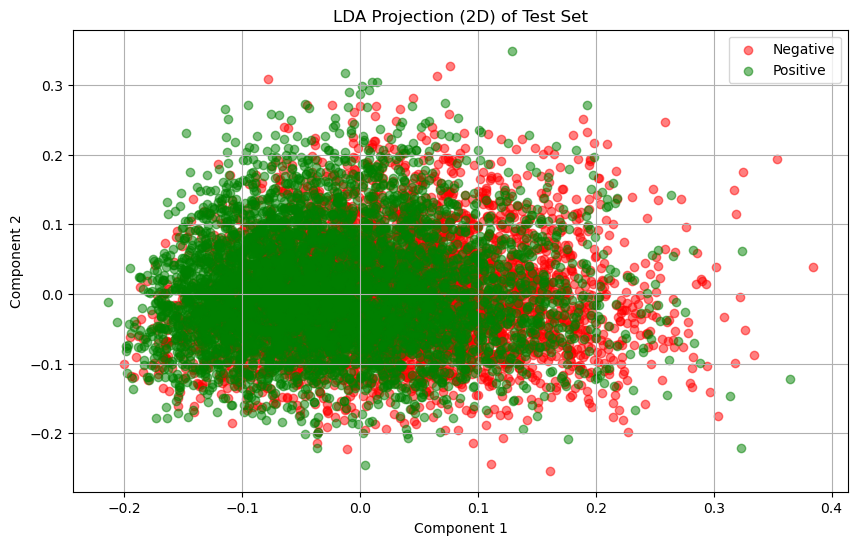

In [59]:

binary_test_sentiments_new = binary_test_sentiments.ravel()

plt.figure(figsize=(10, 6))

plt.scatter(X_test_vis[binary_test_sentiments_new == 0, 0],
            X_test_vis[binary_test_sentiments_new == 0, 1],
            color='red', label='Negative', alpha=0.5)

plt.scatter(X_test_vis[binary_test_sentiments_new == 1, 0],
            X_test_vis[binary_test_sentiments_new == 1, 1],
            color='green', label='Positive', alpha=0.5)

plt.title('LDA Projection (2D) of Test Set')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid(True)
plt.show()


In [60]:
label_map = {0: 'negative', 1: 'positive'}
true_labels_text = [label_map[y] for y in binary_test_sentiments.ravel()]
predicted_labels_text = [label_map[y] for y in lda_predictions]

n_examples = 20 

results_df = pd.DataFrame({
    'Review': n_test_revw[:n_examples].apply(lambda x: x[:100] + '...'),
    'True Label': true_labels_text[:n_examples],
    'Predicted Label': predicted_labels_text[:n_examples],
})

results_df['Correct'] = results_df['True Label'] == results_df['Predicted Label']

def highlight(row):
    color = 'background-color: #d4edda' if row['Correct'] else 'background-color: #f8d7da'
    return [color] * len(row)

styled_df = results_df.style.apply(highlight, axis=1)
display(styled_df)

,Review,True Label,Predicted Label,Correct
40000,first off i want to say that i lean liber on the polit scale and i found the movi offens i manag to ...,negative,negative,True
40001,i wa excit to see a sitcom that would hope repres indian candian but i found thi show to be not funn...,negative,negative,True
40002,when you look at the cover and read stuff about it an entir differ type of movi come to mind than wh...,negative,positive,False
40003,like mani other i count on the appear of denni hopper to make thi not a complet wast of time i wa sa...,negative,negative,True
40004,thi movi wa on tv the other day and i didnt enjoy it at all the first georg of the jungl wa a good c...,negative,negative,True
40005,hickori dickori dock wa a good poirot mysteri i confess i have not read the book despit be an avid a...,positive,positive,True
40006,one crazi summer is the funniest craziest not necessarili the best movi i have ever seenjust when on...,positive,positive,True
40007,lowbudget schlockmeist herschel gordon lewi reach a new low even for him with the gore gore girl a f...,negative,negative,True
40008,thi wa absolut the most tragic pile of cinema to which i have ever born wit not onli wa the name a c...,negative,negative,True
40009,i have never understood the appeal of thi show the act is poor debra jo rupp be a notabl except the ...,negative,negative,True
